Dessa vez sem os componentes da GAN, que não parecem estar dando certo. Tentando apenas usar multitask de emoções com KD.

# Somente dados rotulados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, AutoModel,AutoConfig,get_constant_schedule_with_warmup, BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score,f1_score
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler

import torch
from torch import nn
import time
import random
import datetime
import math

#TODO: ver de fazer o pull request pra ver se o cara arruma essa porcaria de função, ao invés dessa gambiarra
from skmultilearn.skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


tqdm.pandas()

In [2]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [3]:
torch.cuda.is_available()

True

In [4]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0,is_loss=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.is_loss = is_loss
        if is_loss:
            self.min_validation_loss = np.inf
        else:
            self.min_validation_loss = -np.inf

    def early_stop(self, validation_loss):
        if self.is_loss:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW LOWEST LOSS ",self.min_validation_loss)
            elif validation_loss >= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        else:
            if validation_loss > self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW HIGHEST SCORE ",self.min_validation_loss)
            elif validation_loss <= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

In [5]:
stop = EarlyStopper(is_loss=False)

In [6]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
remove_neutral_instances= True

In [8]:
max_length = 128

threshold = 0.5
noise_size = 100
out_dropout_rate = 0.2

unlabeled_ratio = 3

apply_balance = True

learning_rate =  5e-5
epsilon = 1e-8
num_train_epochs = 30
multi_gpu = True

apply_scheduler = True
warmup_proportion = 0.1

T = 3

print_each_n_step = 100

batch_size = 32

model_path = "neuralmind/bert-base-portuguese-cased"
#model_path = "models/go_emotions"

alpha = 0.3


# dados

In [9]:
df = pd.read_csv("data/segredos_sentenças_multitask_clean.csv",index_col=0)


In [10]:
df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)

In [11]:
symptom_num = df.iloc[:,1:].shape[1]
target_names = list(df.iloc[:,1:].columns)

In [12]:
if remove_neutral_instances == True:
    df = df.reset_index(drop=True)
    df = df[df.iloc[:,1:].sum(axis=1) != 0]
    

In [13]:
df = df.reset_index(drop=True)

In [14]:
#label_to_idx = {sintoma:i for i,sintoma in enumerate(label_list)}
#idx_to_label = {i:sintoma for i,sintoma in enumerate(label_list)}

In [15]:
train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)

In [16]:
#unlabeled = pd.read_csv("data/lrec2020.csv",sep=";")
#if unlabeled_ratio:
#    size = train_df.shape[0] * unlabeled_ratio
#    unlabeled = unlabeled.sample(size,random_state=seed_val)

In [17]:
#unlabeled.rename(columns = {'Text':'text'}, inplace = True)

In [18]:
#unlabeled = pd.read_csv("features/goemotions lrec2020.csv").dropna().reset_index(drop=True)

In [19]:
#unlabeled = pd.read_csv("features/goemotions facebook+reddit_sentences.csv")

In [20]:
unlabeled = pd.read_csv("features/goemotions goemotions_train_set.csv")
to_keep = pd.read_csv("data/emotions_to_keep.csv")


In [21]:
idx = to_keep[~to_keep['f1-score']].index
unlabeled = unlabeled.drop(columns=unlabeled.columns[idx])

In [22]:
unlabeled = unlabeled.reset_index(drop=True)

In [23]:
if unlabeled_ratio:
    size = df.shape[0] * unlabeled_ratio
    unlabeled = unlabeled.sample(size,random_state=seed_val)
    unlabeled = unlabeled.reset_index(drop=True)

In [24]:
unlabeled_train, unlabeled_test, _, _ = train_test_split(unlabeled,unlabeled,test_size=0.2,shuffle=True,random_state=42)

In [25]:
#batch size similar ao do baseline, mas relevando a diferença do dataset auxiliar para o primário

#batch_size = batch_size * round(unlabeled_train.shape[0]/train_df.shape[0]) 

In [26]:
batch_size

32

# modelo

In [27]:
transformer = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [28]:
#só pra checar se o modelo tá sendo ajustado
last_transformer_layer = list(transformer.modules())[-4]

In [29]:
if model_path == "models/go_emotions":
    last_layer_auxiliary = list(transformer.modules())[-1]
else:
    last_layer_auxiliary = None

In [30]:
transformer = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
class Multitask(nn.Module):
    def __init__(self,num_primary_labels, num_auxiliary_labels,input_size=512,last_layer_auxiliary=None):
        super(Multitask,self).__init__()
        self.primary_head = nn.Linear(input_size,num_primary_labels)
        if last_layer_auxiliary:
            self.auxiliary_head = last_layer_auxiliary
        else:
            self.auxiliary_head = nn.Linear(input_size,num_auxiliary_labels)


        
        self.sigmoid = torch.sigmoid
        
    def forward(self,input_arr,T):
        primary_logits = self.primary_head(input_arr)
        auxiliary_logits = self.auxiliary_head(input_arr/T)
        primary_probs = self.sigmoid(primary_logits)
        
        return primary_probs,auxiliary_logits


In [32]:
config = AutoConfig.from_pretrained(model_path)
hidden_size = int(config.hidden_size)
model = Multitask(train_df.shape[1]-1,unlabeled.shape[1]-1,input_size = hidden_size,last_layer_auxiliary=last_layer_auxiliary)

In [33]:
if last_layer_auxiliary:
    last_layer_auxiliary.weight

In [34]:
model.auxiliary_head.weight

Parameter containing:
tensor([[-0.0146, -0.0266, -0.0313,  ..., -0.0028, -0.0191, -0.0162],
        [ 0.0132, -0.0311,  0.0004,  ...,  0.0021, -0.0289,  0.0254],
        [-0.0074, -0.0266, -0.0236,  ...,  0.0163, -0.0256, -0.0136],
        ...,
        [-0.0111, -0.0169,  0.0205,  ...,  0.0102, -0.0036,  0.0113],
        [-0.0142,  0.0271,  0.0127,  ..., -0.0267,  0.0015, -0.0356],
        [ 0.0140, -0.0183, -0.0348,  ..., -0.0003,  0.0307, -0.0046]],
       requires_grad=True)

In [35]:
transformer = transformer.to(device)
model = model.to(device)

In [36]:
def get_dataloader(labeled_examples,unlabeled_examples,tokenizer,primary_labels,teacher_logits,batch_size=32):
    inputs = []
    attention_masks = []
    
    for arr in [labeled_examples,unlabeled_examples]:
        for text in arr:
            encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
            inputs.append(encoding['input_ids'])
            attention_masks.append(encoding['attention_mask'])
    
        
    inputs = torch.stack(inputs)
    attention_masks = torch.stack(attention_masks)
    
    temp_labels = np.zeros((len(unlabeled_examples),primary_labels.shape[1]))
    primary_labels = np.concatenate([primary_labels,temp_labels])
    
    primary_labels = torch.tensor(primary_labels,dtype=torch.float)
    
    temp_logits = np.zeros((len(labeled_examples),teacher_logits.shape[1]))
    teacher_logits = np.concatenate([temp_logits,teacher_logits])
    teacher_logits = torch.tensor(teacher_logits,dtype=torch.float)
    
    # quais são rotulados, e quais são não rotulados
    label_mask = np.concatenate([np.ones(len(labeled_examples)),np.zeros(len(unlabeled_examples))])
    
    label_mask = torch.tensor(label_mask,dtype=bool)
    
    dataset = TensorDataset(inputs,attention_masks,primary_labels,teacher_logits,label_mask)
    student_dataloader = DataLoader(dataset,sampler = RandomSampler(dataset),
                        batch_size=batch_size)
    
    return student_dataloader

In [37]:
train_dataloader = get_dataloader(train_df.text,unlabeled_train.text,tokenizer,train_df.iloc[:,1:].to_numpy(),unlabeled_train.iloc[:,:-1].to_numpy(),batch_size)
test_dataloader = get_dataloader(test_df.text,unlabeled_test.text,tokenizer,test_df.iloc[:,1:].to_numpy(),unlabeled_test.iloc[:,:-1].to_numpy(),batch_size)


In [38]:
def focal_binary_cross_entropy(p, targets, gamma=4):
    #l = logits.reshape(-1)
    #t = targets.reshape(-1)
    #p = torch.sigmoid(l)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    num_label = targets.shape[1]
    loss = num_label*loss.mean()
    return loss

In [39]:
def new_and_improved(p,targets,gamma=3,alpha=0.8):
    bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
    p = torch.where(targets == 1,p,1-p)
    alpha = targets * alpha + (1-targets) * (1 - alpha)
    return (alpha * (1 - p) ** gamma).mean()

In [40]:
def find_best_threshold(true_labels, probs):
    eps=1e-10
    thresholds = [i*0.1 for i in range(1,10)]
    max_score = 0
    for threshold in thresholds:
        cur_score = f1_score(true_labels,probs>threshold,average="macro")
        if cur_score > max_score:
            max_score = cur_score
            best_threshold = threshold
    return best_threshold

In [41]:
#transformer = torch.compile(transformer)

In [42]:
training_stats= []

log_var_a = torch.zeros((1,), requires_grad=True,device=device)
log_var_b = torch.zeros((1,), requires_grad=True,device=device)


transformer_vars = [i for i in transformer.parameters()]

model_vars = transformer_vars + [i for i in model.parameters()] + [log_var_a] + [log_var_b]

optimizer = torch.optim.AdamW(model_vars,lr=learning_rate)

primary_loss_func = new_and_improved
auxiliary_loss_func = torch.nn.KLDivLoss(reduction = "batchmean")

best_f1 = 0
best_epoch = 0
best_report = {}
best_auc = 0
for epoch_i in range(num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()
    tr_loss = 0
    p_tr_loss = 0
    a_tr_loss = 0 
    transformer.train()
    model.train()
    
    labeled_num = 0
    unlabeled_num = 0
    all_probs = []
    all_labels_ids = []
    
    for step,batch in enumerate(train_dataloader):

        
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_labels = batch[2].to(device)
        b_teacher_logits = batch[3].to(device)/T
        b_label_mask = batch[4].to(device)
        
        transformer_outputs = transformer(b_input_ids,attention_mask=b_attention_mask)[-1]

        primary_probs,auxiliary_logits = model(transformer_outputs,T)
        
        #filtering        
        primary_probs = primary_probs[b_label_mask]
        b_labels = b_labels[b_label_mask]
        
        b_teacher_logits = b_teacher_logits[~b_label_mask]
        auxiliary_logits = auxiliary_logits[~b_label_mask]
        
        
        if (~b_label_mask).sum() > 0:
            student_output = torch.nn.functional.log_softmax(auxiliary_logits)
            teacher_output = torch.nn.functional.softmax(b_teacher_logits)
        
            auxiliary_loss = auxiliary_loss_func(student_output,teacher_output)
            a_tr_loss += auxiliary_loss
            unlabeled_num += 1
        
        else:
            auxiliary_loss = 0
            
        if(b_label_mask).sum() > 0:
            primary_loss = primary_loss_func(primary_probs,b_labels)
            p_tr_loss += primary_loss
            labeled_num += 1
        
        else:
            primary_loss = 0

        batch_loss = primary_loss * (1-alpha) + auxiliary_loss * alpha
        
        #batch_loss = (primary_loss * torch.exp(-log_var_a) +log_var_a) + (auxiliary_loss * torch.exp(-log_var_b) + log_var_b) 

        
        optimizer.zero_grad()

        
            
        batch_loss.backward()
        optimizer.step()
        
        
        all_probs += primary_probs.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        
        tr_loss += batch_loss.item()
        
        
    all_probs = torch.stack(all_probs).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    
    threshold = find_best_threshold(all_labels_ids,all_probs)
    print("best threshold: ",threshold)
    
    avg_train_loss = tr_loss/len(train_dataloader)
    avg_primary_loss = p_tr_loss/labeled_num
    avg_aux_loss = a_tr_loss/unlabeled_num
    training_time = format_time(time.time()-t0)
    
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Average prim. training loss: {0:.3f}".format(avg_primary_loss))
    print("  Average aux. training loss: {0:.3f}".format(avg_aux_loss))

    print("  Training epoch took: {:}".format(training_time))
    print("Num unlabeled batches:",unlabeled_num)
    print("Num labeled batches",labeled_num)

    transformer.eval()
    model.eval()
    t0 = time.time()
    
    total_test_loss = 0
    primary_test_loss = 0
    auxiliary_test_loss = 0
    
    
    num_labeled = 0
    num_unlabeled = 0
    all_preds = []
    all_labels_ids = []
    all_probs = []
    
    for batch in test_dataloader:
        
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_labels = batch[2].to(device)
        b_teacher_logits = batch[3].to(device)/T
        b_label_mask = batch[4].to(device)        
        with torch.no_grad():
            transformer_outputs = transformer(b_input_ids,attention_mask=b_attention_mask)[-1]

            primary_probs,auxiliary_logits = model(transformer_outputs,T)
            
            #filtering        
            primary_probs = primary_probs[b_label_mask]
            b_labels = b_labels[b_label_mask]
        
            b_teacher_logits = b_teacher_logits[~b_label_mask]
            auxiliary_logits = auxiliary_logits[~b_label_mask]
            
            if (~b_label_mask).sum() > 0:
                student_output = torch.nn.functional.log_softmax(auxiliary_logits)
                teacher_output = torch.nn.functional.softmax(b_teacher_logits)
        
                auxiliary_loss = auxiliary_loss_func(student_output,teacher_output)
                auxiliary_test_loss += auxiliary_loss.item()
                num_unlabeled += 1
            else:
                auxiliary_loss = 0
        
            if(b_label_mask).sum() > 0:
                primary_loss = primary_loss_func(primary_probs,b_labels)
                primary_test_loss += primary_loss.item()
                num_labeled += 1
        
            else:
                primary_loss = 0
        
            total_test_loss += primary_loss * (1-alpha) + auxiliary_loss * alpha
            #total_test_loss = (primary_loss * torch.exp(-log_var_a) +log_var_a) + (auxiliary_loss * torch.exp(-log_var_b) + log_var_b) 

            
            
        all_probs += primary_probs.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        
    all_probs = torch.stack(all_probs).numpy()
    all_preds = all_probs > threshold
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    
    cur_auc = roc_auc_score(all_labels_ids,all_probs)
    
    if cur_auc > best_auc:
        best_auc = cur_auc
        best_auc_epoch = epoch_i
        
    cur_report = classification_report(all_labels_ids,all_preds,target_names=target_names, zero_division=0,output_dict=True)
    if cur_report['macro avg']['f1-score'] >= best_f1:
        best_f1 = cur_report['macro avg']['f1-score']
        best_epoch = epoch_i
        best_report = cur_report
        
    avg_test_loss = total_test_loss/len(test_dataloader)
    
    
    auxiliary_test_loss = auxiliary_test_loss / num_unlabeled
    
    primary_test_loss = primary_test_loss / num_labeled

    test_time = format_time(time.time() - t0)
    
    print("F1-score: ",cur_report['macro avg']['f1-score'])
    print("  Test Loss: {0:.3f}".format(avg_test_loss.item()))
    print("  Test Auxiliary Loss: {0:.3f}".format(auxiliary_test_loss))
    print("  Test Primary Loss: {0:.3f}".format(primary_test_loss))
    if stop.early_stop(cur_auc):
        break
    print("  Test took: {:}".format(test_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss.item(),
            'F1-score':cur_report['macro avg']['f1-score'],
            'Training Primary Loss': avg_primary_loss.item(),
            'Test Primary Loss': primary_test_loss,
            'Training Aux Loss': avg_aux_loss.item(),
            'Test Aux Loss': auxiliary_test_loss,
            'Training Time': training_time,
            'Test Time': test_time
        })


    


======== Epoch 1 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.4
  Average training loss: 0.058
  Average prim. training loss: 0.021
  Average aux. training loss: 0.146
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 144


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.18538781454878825
  Test Loss: 0.030
  Test Auxiliary Loss: 0.059
  Test Primary Loss: 0.017
NEW HIGHEST SCORE  0.7265786306221584
  Test took: 0:00:03

======== Epoch 2 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.023
  Average prim. training loss: 0.015
  Average aux. training loss: 0.042
  Training epoch took: 0:00:25
Num unlabeled batches: 145
Num labeled batches 145


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.3218742902789131
  Test Loss: 0.020
  Test Auxiliary Loss: 0.035
  Test Primary Loss: 0.014
NEW HIGHEST SCORE  0.8326210239590998
  Test took: 0:00:03

======== Epoch 3 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.014
  Average prim. training loss: 0.011
  Average aux. training loss: 0.022
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 144


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.37976992639122364
  Test Loss: 0.018
  Test Auxiliary Loss: 0.030
  Test Primary Loss: 0.013
NEW HIGHEST SCORE  0.8632677710499853
  Test took: 0:00:03

======== Epoch 4 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.010
  Average prim. training loss: 0.008
  Average aux. training loss: 0.015
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 145


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.4002241681498735
  Test Loss: 0.016
  Test Auxiliary Loss: 0.026
  Test Primary Loss: 0.012
NEW HIGHEST SCORE  0.8845591427603146
  Test took: 0:00:03

======== Epoch 5 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.007
  Average prim. training loss: 0.005
  Average aux. training loss: 0.012
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 144


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.4633803001907292
  Test Loss: 0.015
  Test Auxiliary Loss: 0.023
  Test Primary Loss: 0.012
NEW HIGHEST SCORE  0.8846636479001183
  Test took: 0:00:03

======== Epoch 6 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.005
  Average prim. training loss: 0.004
  Average aux. training loss: 0.009
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 144


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.46460299752920975
  Test Loss: 0.016
  Test Auxiliary Loss: 0.023
  Test Primary Loss: 0.012
NEW HIGHEST SCORE  0.8914682363500541
  Test took: 0:00:03

======== Epoch 7 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.004
  Average prim. training loss: 0.003
  Average aux. training loss: 0.008
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 145


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.45705356411255305
  Test Loss: 0.016
  Test Auxiliary Loss: 0.022
  Test Primary Loss: 0.013
  Test took: 0:00:03

======== Epoch 8 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.004
  Average prim. training loss: 0.002
  Average aux. training loss: 0.008
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 145


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.4443953694802371
  Test Loss: 0.016
  Test Auxiliary Loss: 0.023
  Test Primary Loss: 0.014
  Test took: 0:00:03

======== Epoch 9 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.003
  Average prim. training loss: 0.002
  Average aux. training loss: 0.007
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 143


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.46813930854061525
  Test Loss: 0.016
  Test Auxiliary Loss: 0.021
  Test Primary Loss: 0.014
  Test took: 0:00:03

======== Epoch 10 / 30 ========
Training...


/tmp/ipykernel_207359/889554439.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    145.    Elapsed: 0:00:18.
best threshold:  0.5
  Average training loss: 0.003
  Average prim. training loss: 0.001
  Average aux. training loss: 0.006
  Training epoch took: 0:00:26
Num unlabeled batches: 145
Num labeled batches 145


/tmp/ipykernel_207359/889554439.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(auxiliary_logits)
/tmp/ipykernel_207359/889554439.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


F1-score:  0.4918745654728378
  Test Loss: 0.016
  Test Auxiliary Loss: 0.020
  Test Primary Loss: 0.014


In [43]:
best_fine_tuning_report = best_report
best_fine_tuning_epoch = best_epoch

In [44]:
print("BEST AUC: ",best_auc)
print("epoch: ",best_auc_epoch)

BEST AUC:  0.8914682363500541
epoch:  5


<AxesSubplot:>

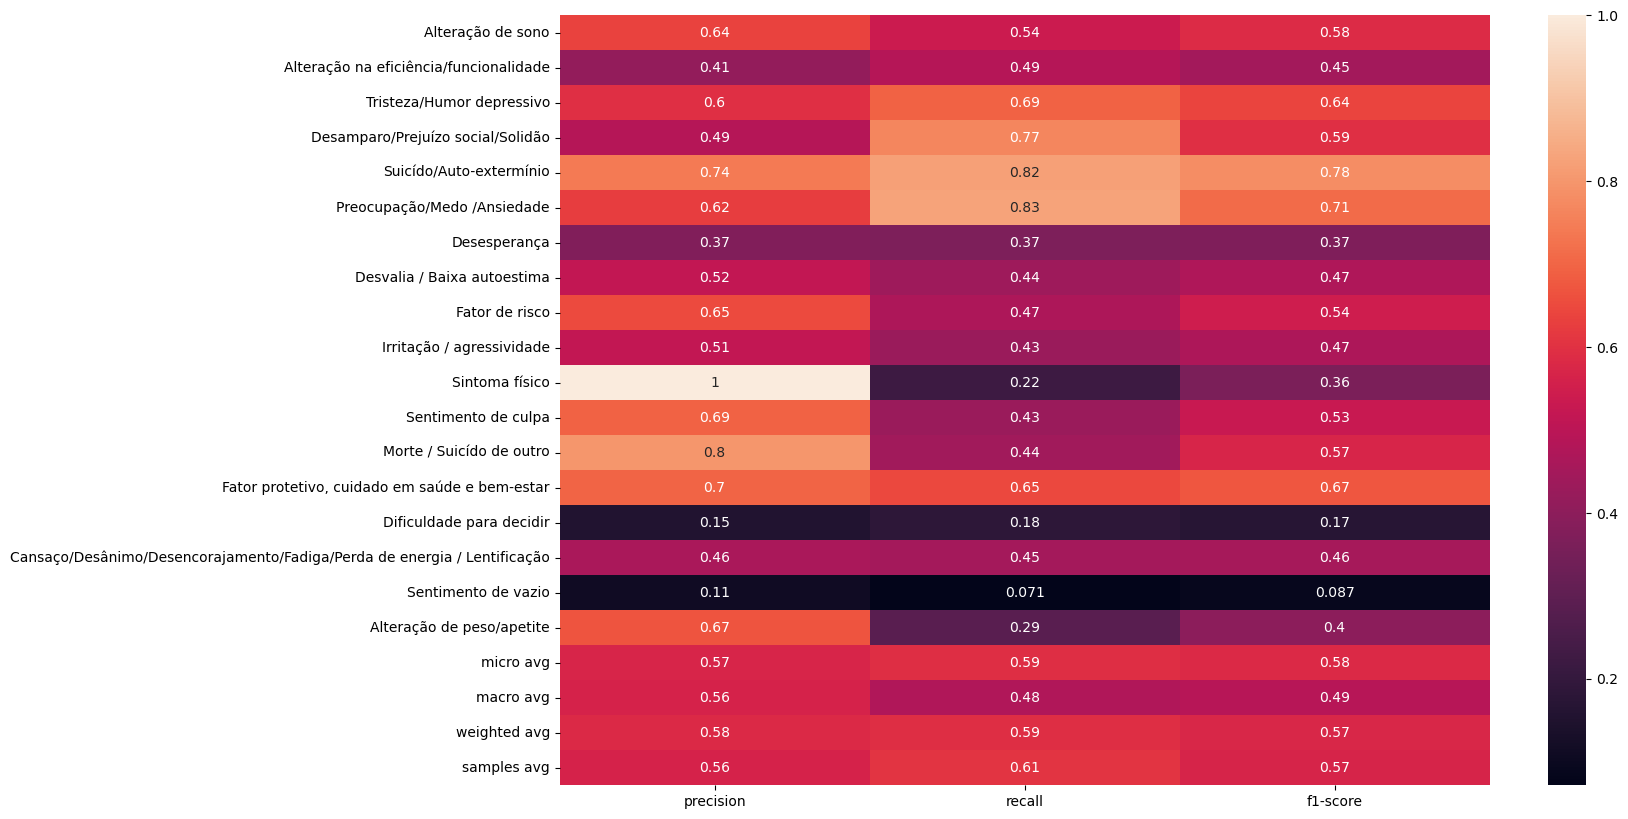

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

In [46]:
test_df.iloc[:,1:].sum(axis=0)

Alteração de sono                                                            13.0
Alteração na eficiência/funcionalidade                                       39.0
Tristeza/Humor depressivo                                                   140.0
Desamparo/Prejuízo social/Solidão                                           128.0
Suicído/Auto-extermínio                                                     112.0
Preocupação/Medo /Ansiedade                                                  58.0
Desesperança                                                                 52.0
Desvalia / Baixa autoestima                                                  71.0
Fator de risco                                                              126.0
Irritação / agressividade                                                    42.0
Sintoma físico                                                                9.0
Sentimento de culpa                                                          21.0
Morte / Suicído 

In [47]:
print("epoch: ",best_epoch)

epoch:  9


In [48]:
losses = pd.DataFrame(training_stats)[["Training Loss", "Test Loss","F1-score",'Test Aux Loss','Training Aux Loss',
                                      'Training Primary Loss', 'Test Primary Loss']]

In [49]:
losses

,Training Loss,Test Loss,F1-score,Test Aux Loss,Training Aux Loss,Training Primary Loss,Test Primary Loss
0,0.058178,0.029731,0.185388,0.059384,0.145591,0.020859,0.017022
1,0.023461,0.020388,0.321874,0.035382,0.042091,0.015477,0.013962
2,0.014075,0.017756,0.379770,0.029703,0.021796,0.010841,0.012636
3,0.009965,0.016462,0.400224,0.026034,0.014632,0.007965,0.012360
4,0.007157,0.015492,0.463380,0.023027,0.011669,0.005260,0.012263
5,0.005338,0.015577,0.464603,0.022886,0.009099,0.003752,0.012444
6,0.004498,0.015831,0.457054,0.021725,0.008247,0.002891,0.013305
7,0.003765,0.016294,0.444395,0.022509,0.007540,0.002148,0.013630
8,0.003089,0.015852,0.468139,0.020772,0.006685,0.001570,0.013744


# checando se o modelo ainda classifica emoções

In [50]:
go_emotions_path = "data/goemotions"
test = pd.read_csv(f"{go_emotions_path}/test.tsv",sep='\t')
emotion_dict = {
    "admiração": 0,
    "diversão": 1,
    "raiva": 2,
    "aborrecimento": 3,
    "aprovação": 4,
    "zelo": 5,
    "confusão": 6,
    "curiosidade": 7,
    "desejo": 8,
    "decepção": 9,
    "desaprovação": 10,
    "nojo": 11,
    "constrangimento": 12,
    "entusiasmo": 13,
    "medo": 14,
    "gratidão": 15,
    "luto": 16,
    "alegria": 17,
    "amor": 18,
    "nervosismo": 19,
    "otimismo": 20,
    "orgulho": 21,
    "percepção": 22,
    "alívio": 23,
    "remorso": 24,
    "tristeza": 25,
    "surpresa": 26,
    "neutro": 27
}

In [51]:
drop = []
for key in emotion_dict:
    if emotion_dict[key] in list(idx):
        drop.append(key)
for key in drop:
    del emotion_dict[key]

In [52]:
def filter_dropped(row,idx):
    for label in row.labels.split(","):
        if int(label) in list(idx):
            return {}
    return row

In [53]:
test = test.apply(lambda x: filter_dropped(x,idx),axis=1).dropna()

In [54]:
def change_label_encoding(row):
    labels = row['labels'].replace(" ","").split(",")
    new_row = {}
    for emotion in emotion_dict:
        if str(emotion_dict[emotion]) in labels:
            new_row[emotion] = True
        else:
            new_row[emotion] = False
    return new_row

In [55]:
test_labels = pd.DataFrame(list(test.apply(change_label_encoding,axis=1)))
test_inputs = list(test.text.apply(lambda x: x[:512] if len(x) > 512 else x))


In [56]:
inputs = []
attention_masks =[]
for text in test_inputs:
    encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    inputs.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])
        
inputs = torch.stack(inputs)
attention_masks = torch.stack(attention_masks)

dataset = TensorDataset(inputs, attention_masks)
emotion_dataloader = DataLoader(
              dataset,
              sampler = SequentialSampler(dataset), 
              batch_size = batch_size)

In [57]:
transformer = transformer.to(device)
softmax = torch.nn.Softmax()
predictions = []
threshold = 0.3
for step,batch in enumerate(emotion_dataloader):
        b_input_ids = batch[0].reshape(len(batch[0]),max_length).to(device)
        b_attention_mask = batch[1].reshape(len(batch[0]),max_length).to(device)
       
        
        with torch.no_grad():
            transformer_outputs = transformer(b_input_ids,attention_mask=b_attention_mask)[-1]
            _,auxiliary_logits = model(transformer_outputs,T=1)
            for b_pred in (torch.nn.functional.softmax(auxiliary_logits).detach().cpu() > threshold):
                predictions.append(b_pred)
predictions = torch.stack(predictions) 

/tmp/ipykernel_207359/3471756121.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for b_pred in (torch.nn.functional.softmax(auxiliary_logits).detach().cpu() > threshold):


<AxesSubplot:>

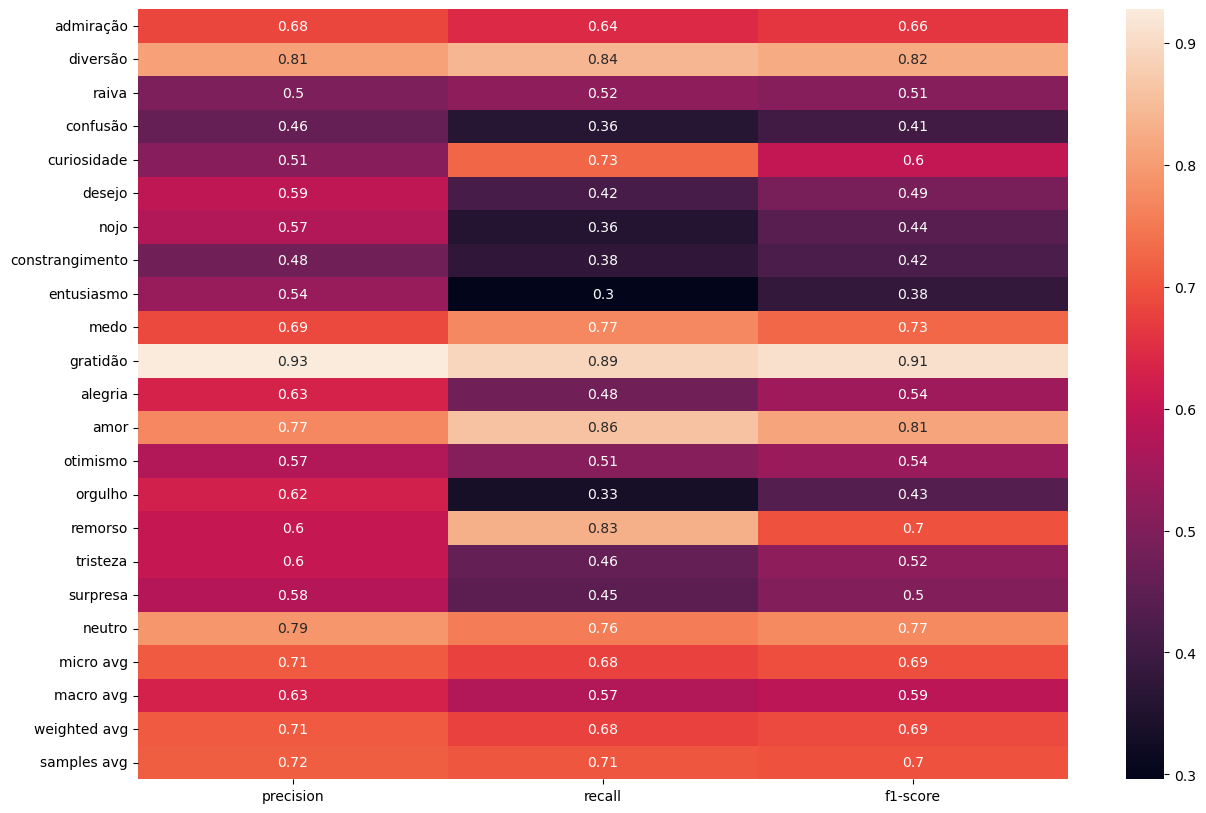

In [58]:

emotion_results = classification_report(np.array(test_labels),np.array(predictions),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(emotion_results).iloc[:-1, :].T, annot=True)

In [59]:
last_transformer_layer.weight


Parameter containing:
tensor([[-0.0223,  0.0347, -0.0037,  ...,  0.0107,  0.0089, -0.0196],
        [-0.0215,  0.0091,  0.0119,  ...,  0.0074,  0.0001, -0.0075],
        [-0.0170, -0.0092,  0.0075,  ...,  0.0070, -0.0148, -0.0221],
        ...,
        [ 0.0088, -0.0067, -0.0040,  ..., -0.0047, -0.0080,  0.0106],
        [ 0.0097,  0.0006,  0.0133,  ...,  0.0034,  0.0028,  0.0323],
        [ 0.0142, -0.0125,  0.0148,  ...,  0.0109,  0.0181,  0.0056]],
       requires_grad=True)

In [60]:
list(transformer.modules())[-2].weight

Parameter containing:
tensor([[-0.0244,  0.0372, -0.0039,  ...,  0.0058,  0.0118, -0.0236],
        [-0.0187,  0.0106,  0.0014,  ...,  0.0026, -0.0002, -0.0079],
        [-0.0181, -0.0073,  0.0023,  ...,  0.0111, -0.0156, -0.0186],
        ...,
        [ 0.0191, -0.0117,  0.0011,  ..., -0.0043, -0.0135,  0.0090],
        [ 0.0044,  0.0067,  0.0096,  ...,  0.0028,  0.0055,  0.0280],
        [ 0.0151, -0.0155,  0.0210,  ...,  0.0163,  0.0180,  0.0069]],
       device='cuda:0', requires_grad=True)